In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram

In [2]:
from scipy.cluster.hierarchy import cut_tree

In [3]:
retail=pd.read_csv('/content/OnlineRetail.csv', sep=",", encoding="ISO-8859-1", header=0)

In [4]:
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [5]:


retail.shape

(24721, 8)

In [6]:


retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24721 entries, 0 to 24720
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    24721 non-null  object 
 1   StockCode    24721 non-null  object 
 2   Description  24610 non-null  object 
 3   Quantity     24721 non-null  int64  
 4   InvoiceDate  24721 non-null  object 
 5   UnitPrice    24721 non-null  float64
 6   CustomerID   16030 non-null  float64
 7   Country      24721 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 1.5+ MB


In [7]:

retail.describe()

,Quantity,UnitPrice,CustomerID
count,24721.000000,24721.000000,16030.00000
mean,7.287165,7.103063,15575.83219
std,70.793963,181.932783,1782.23384
min,-9360.000000,0.000000,12347.00000
25%,1.000000,1.450000,14135.00000
50%,2.000000,2.510000,15658.00000
75%,6.000000,4.250000,17223.00000
max,2880.000000,13541.330000,18269.00000


Step 2 : Data Cleansing

In [8]:
df_null = round(100*(retail.isnull().sum())/len(retail), 2)
df_null

InvoiceNo       0.00
StockCode       0.00
Description     0.45
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     35.16
Country         0.00
dtype: float64

In [9]:
retail = retail.dropna()
retail.shape

(16030, 8)

In [10]:
retail['CustomerID'] = retail['CustomerID'].astype(str)

In [11]:
retail['Amount'] = retail['Quantity']*retail['UnitPrice']
rfm_m = retail.groupby('CustomerID')['Amount'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()

,CustomerID,Amount
0,12347.0,711.79
1,12386.0,258.90
2,12395.0,346.10
3,12427.0,303.50
4,12429.0,1281.50


In [12]:
rfm_f = retail.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head()

,CustomerID,Frequency
0,12347.0,31
1,12386.0,8
2,12395.0,12
3,12427.0,10
4,12429.0,20


In [13]:
rfm = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')
rfm.head()

,CustomerID,Amount,Frequency
0,12347.0,711.79,31
1,12386.0,258.90,8
2,12395.0,346.10,12
3,12427.0,303.50,10
4,12429.0,1281.50,20


In [14]:
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'],format='%d-%m-%Y %H:%M')

In [15]:
max_date = max(retail['InvoiceDate'])
max_date

Timestamp('2010-12-10 14:54:00')

In [16]:
retail['Diff'] = max_date - retail['InvoiceDate']
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,9 days 06:28:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,9 days 06:28:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,9 days 06:28:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,9 days 06:28:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,9 days 06:28:00


In [17]:
rfm_p = retail.groupby('CustomerID')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head()

,CustomerID,Diff
0,12347.0,2 days 23:57:00
1,12386.0,2 days 05:01:00
2,12395.0,6 days 22:19:00
3,12427.0,7 days 04:10:00
4,12429.0,1 days 02:49:00


In [18]:
rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head()

,CustomerID,Diff
0,12347.0,2
1,12386.0,2
2,12395.0,6
3,12427.0,7
4,12429.0,1


In [19]:
rfm = pd.merge(rfm, rfm_p, on='CustomerID', how='inner')
rfm.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
rfm.head()

,CustomerID,Amount,Frequency,Recency
0,12347.0,711.79,31,2
1,12386.0,258.90,8,2
2,12395.0,346.10,12,6
3,12427.0,303.50,10,7
4,12429.0,1281.50,20,1


Text(0.5, 0, 'Attributes')

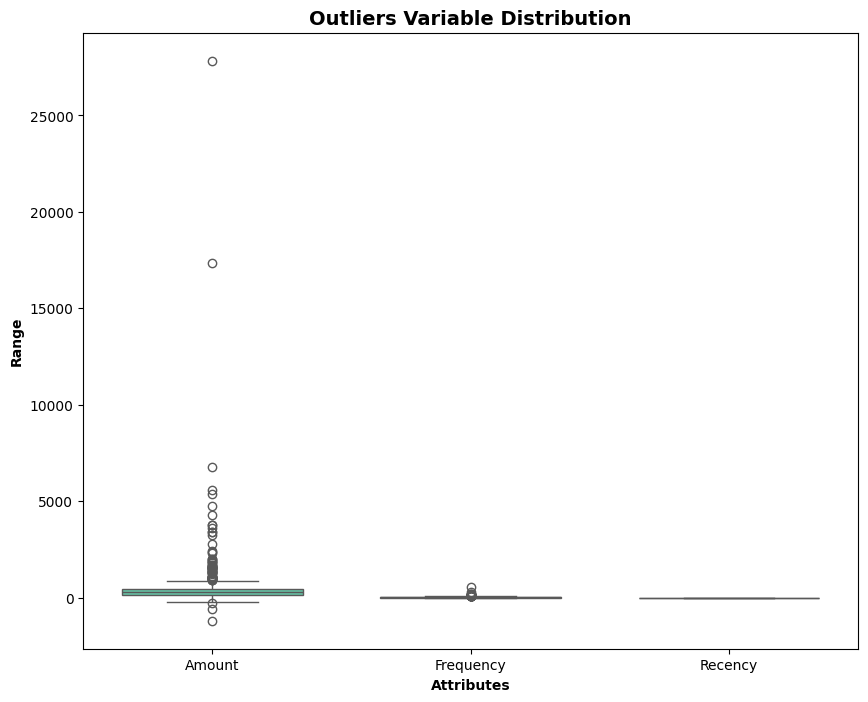

In [20]:
attributes = ['Amount','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [21]:
Q1 = rfm.Amount.quantile(0.05)
Q3 = rfm.Amount.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Amount >= Q1 - 1.5*IQR) & (rfm.Amount <= Q3 + 1.5*IQR)]


Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]


Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]



In [22]:
rfm_df = rfm[['Amount', 'Frequency', 'Recency']]


scaler = StandardScaler()


rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(645, 3)

In [23]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()

,Amount,Frequency,Recency
0,0.665925,0.345378,-0.619414
1,-0.276506,-0.601874,-0.619414
2,-0.095049,-0.437134,0.745307
3,-0.183697,-0.519504,1.086488
4,1.851450,-0.107655,-0.960595


In [24]:
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(max_iter=50, n_clusters=4)

In [25]:
kmeans.labels_

array([1, 1, 2, 2, 0, 2, 0, 1, 0, 3, 1, 1, 1, 2, 0, 2, 1, 2, 1, 1, 3, 1,
       2, 3, 3, 3, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 0, 1, 3, 2, 1, 2, 2, 1,
       1, 1, 3, 1, 3, 2, 2, 1, 1, 1, 2, 1, 1, 2, 1, 0, 1, 1, 1, 2, 0, 1,
       3, 2, 2, 1, 2, 3, 1, 1, 0, 0, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1,
       2, 1, 3, 1, 3, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 3, 2, 0, 1,
       1, 1, 1, 1, 0, 2, 1, 1, 2, 2, 1, 1, 3, 1, 2, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 1, 1, 0, 1, 1, 1, 2, 1, 2, 3, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1,
       1, 2, 1, 0, 1, 1, 2, 1, 1, 1, 2, 3, 1, 3, 1, 2, 1, 3, 2, 2, 2, 1,
       2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 3, 3, 1, 3, 2, 2, 2, 3, 1,
       2, 3, 1, 2, 0, 2, 1, 1, 1, 1, 2, 3, 0, 1, 2, 1, 1, 1, 2, 3, 3, 2,
       2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 2,
       3, 1, 0, 2, 3, 1, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 1, 1, 1, 2, 1, 0, 3, 1, 3, 1, 0, 1, 2,

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

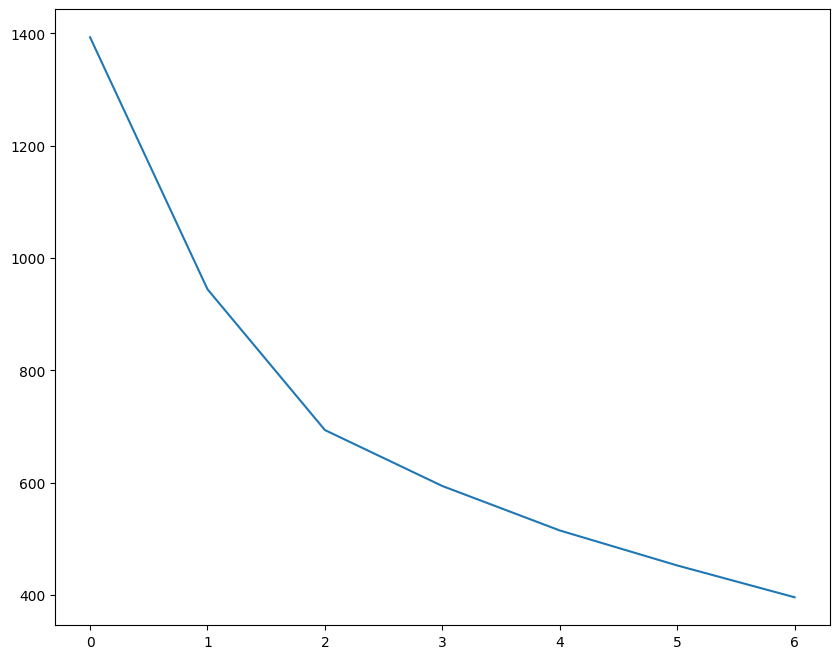

In [26]:
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)

    ssd.append(kmeans.inertia_)


plt.plot(ssd)

In [27]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:


    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)

    cluster_labels = kmeans.labels_

    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=2, the silhouette score is 0.4088559811925606


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=3, the silhouette score is 0.40944690705419534


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=4, the silhouette score is 0.441854141142589
For n_clusters=5, the silhouette score is 0.4324017441825419


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=6, the silhouette score is 0.4480814382690101
For n_clusters=7, the silhouette score is 0.40788576195975057


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=8, the silhouette score is 0.3548410213089211


In [28]:
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(max_iter=50, n_clusters=3)

In [29]:
 kmeans.labels_

array([0, 0, 1, 1, 2, 1, 2, 0, 2, 2, 0, 0, 0, 1, 2, 1, 0, 1, 0, 0, 2, 0,
       1, 2, 2, 2, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 2, 0, 2, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 2, 0,
       2, 1, 1, 0, 1, 1, 0, 0, 2, 2, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 2, 0, 2, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 2, 1, 2, 2,
       0, 0, 0, 0, 2, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 2, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 2, 0, 0, 1, 0, 0, 0, 1, 2, 0, 1, 0, 1, 0, 2, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 2, 0, 2, 1, 1, 1, 2, 0,
       1, 2, 0, 1, 2, 1, 0, 0, 0, 0, 1, 1, 2, 0, 1, 0, 0, 0, 1, 2, 2, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 2, 1, 2, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 2, 0, 0, 2, 0, 2, 0, 1,

In [30]:
rfm['Cluster_Id'] = kmeans.labels_
rfm.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id
0,12347.0,711.79,31,2,0
1,12386.0,258.90,8,2,0
2,12395.0,346.10,12,6,1
3,12427.0,303.50,10,7,1
4,12429.0,1281.50,20,1,2


<Axes: xlabel='Cluster_Id', ylabel='Amount'>

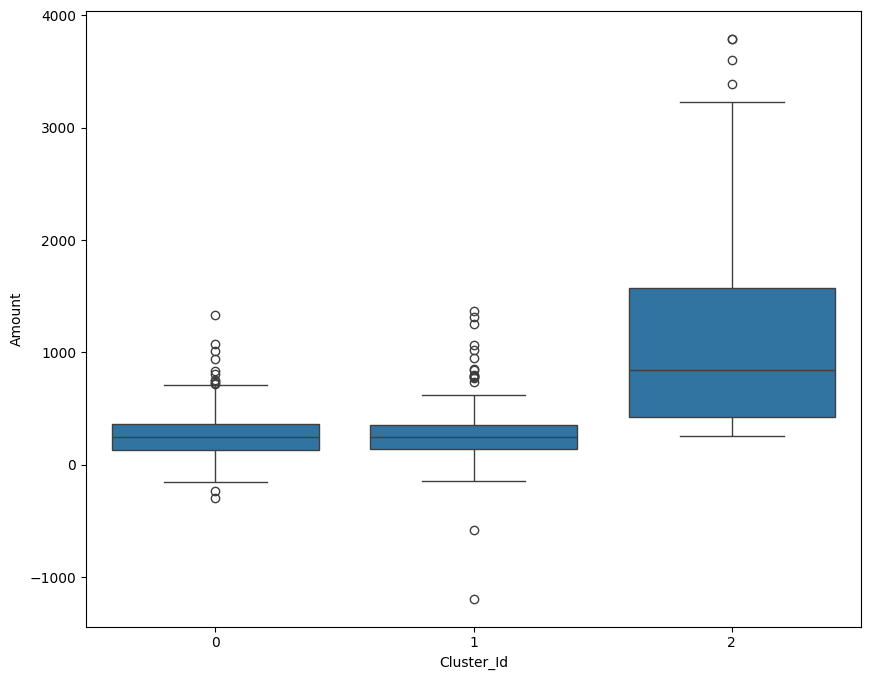

In [31]:
sns.boxplot(x='Cluster_Id', y='Amount', data=rfm)

<Axes: xlabel='Cluster_Id', ylabel='Frequency'>

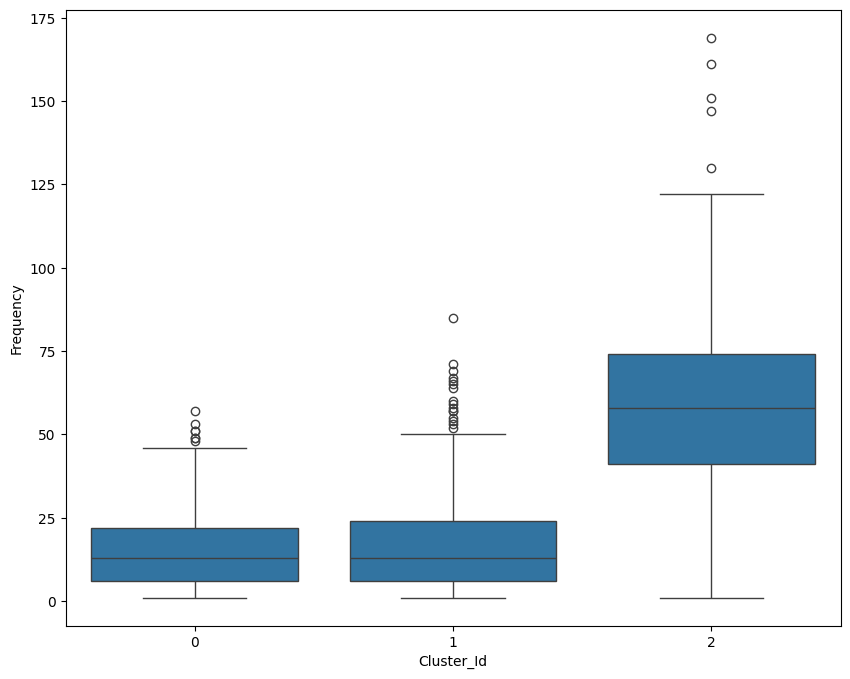

In [32]:
sns.boxplot(x='Cluster_Id', y='Frequency', data=rfm)

<Axes: xlabel='Cluster_Id', ylabel='Recency'>

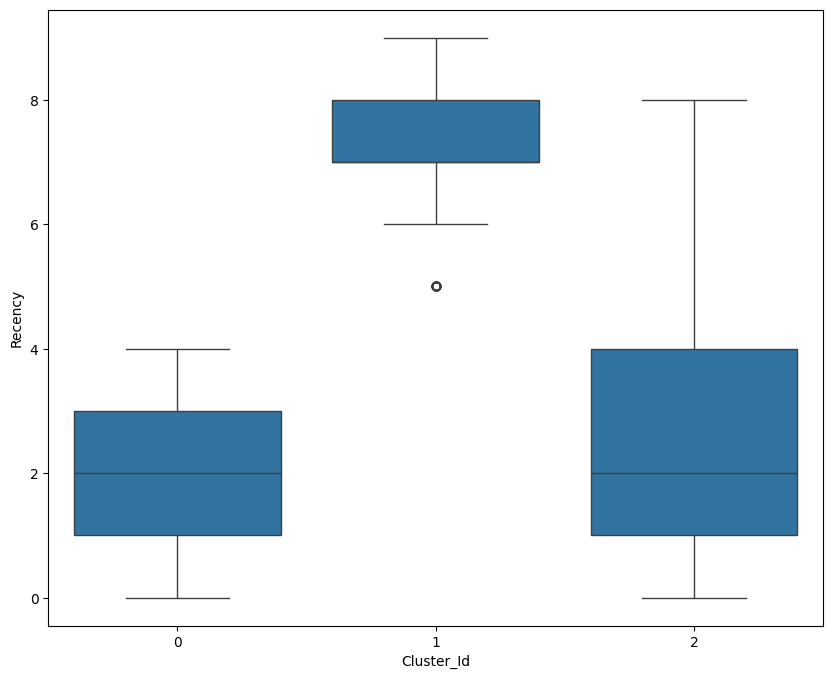

In [33]:
sns.boxplot(x='Cluster_Id', y='Recency', data=rfm)

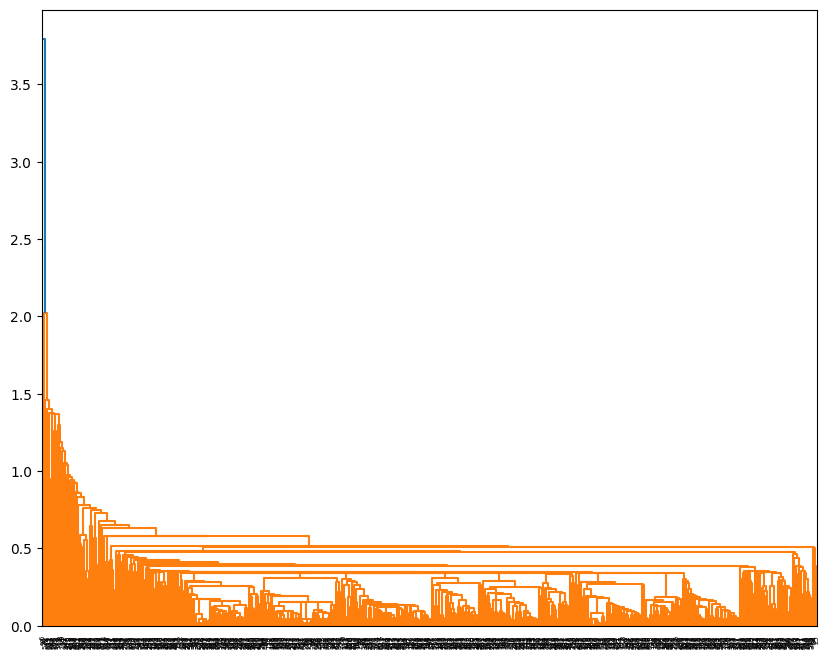

In [34]:
mergings = linkage(rfm_df_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

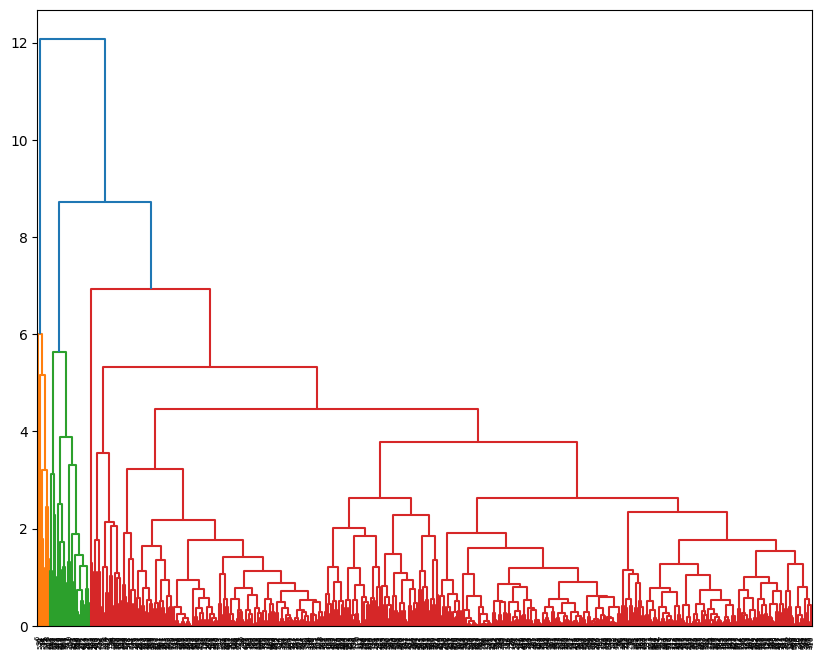

In [35]:
mergings = linkage(rfm_df_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

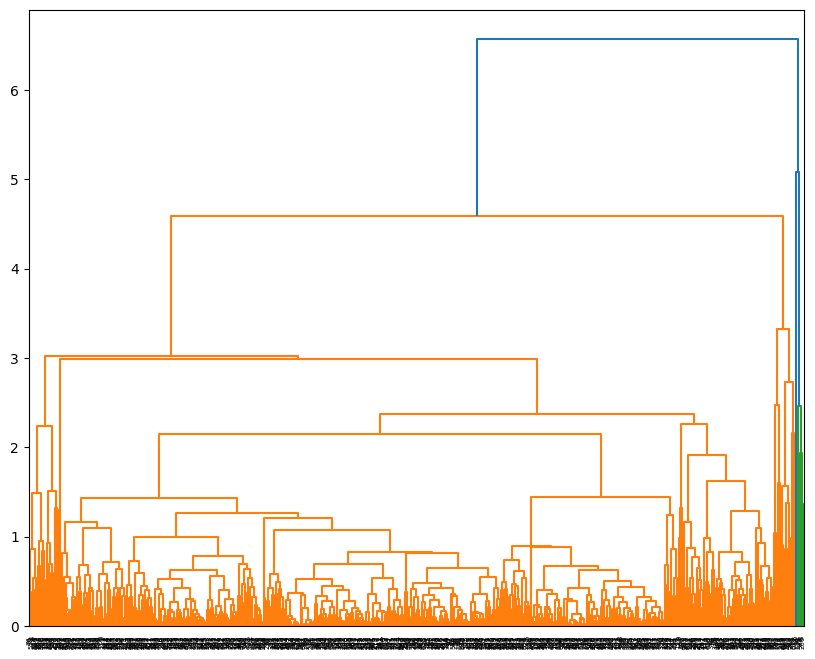

In [36]:
mergings = linkage(rfm_df_scaled, method="average", metric='euclidean')
dendrogram(mergings)
plt.show()

In [37]:
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [38]:
rfm['Cluster_Labels'] = cluster_labels
rfm.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id,Cluster_Labels
0,12347.0,711.79,31,2,0,0
1,12386.0,258.90,8,2,0,0
2,12395.0,346.10,12,6,1,0
3,12427.0,303.50,10,7,1,0
4,12429.0,1281.50,20,1,2,0


<Axes: xlabel='Cluster_Labels', ylabel='Amount'>

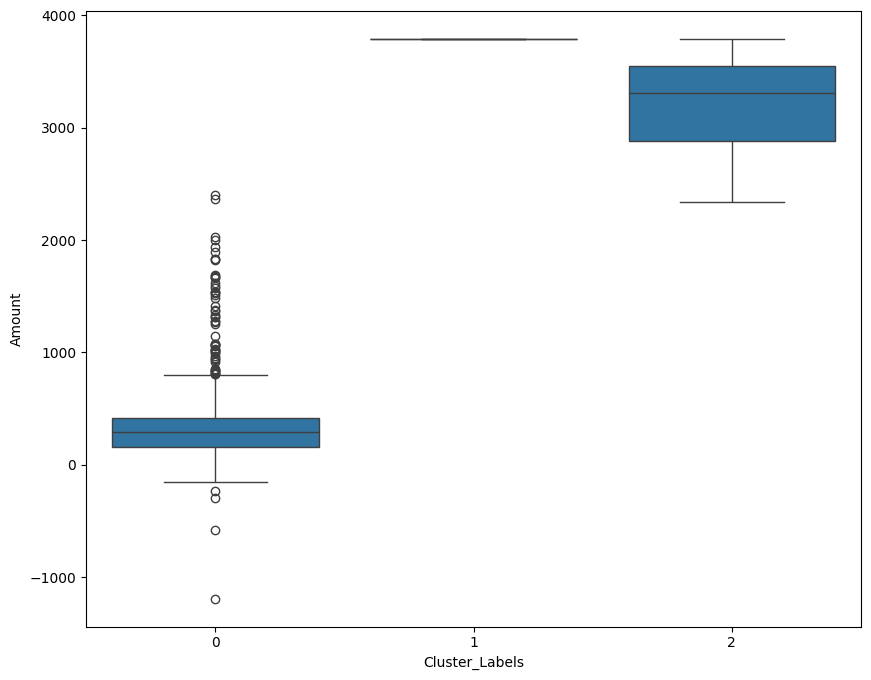

In [39]:
sns.boxplot(x='Cluster_Labels', y='Amount', data=rfm)

<Axes: xlabel='Cluster_Labels', ylabel='Frequency'>

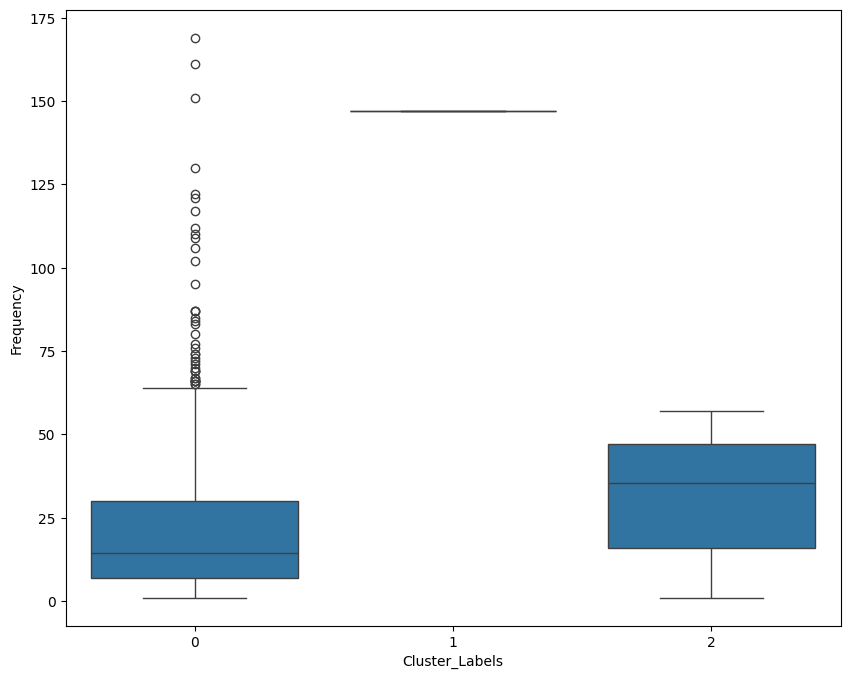

In [40]:
sns.boxplot(x='Cluster_Labels', y='Frequency', data=rfm)

<Axes: xlabel='Cluster_Labels', ylabel='Recency'>

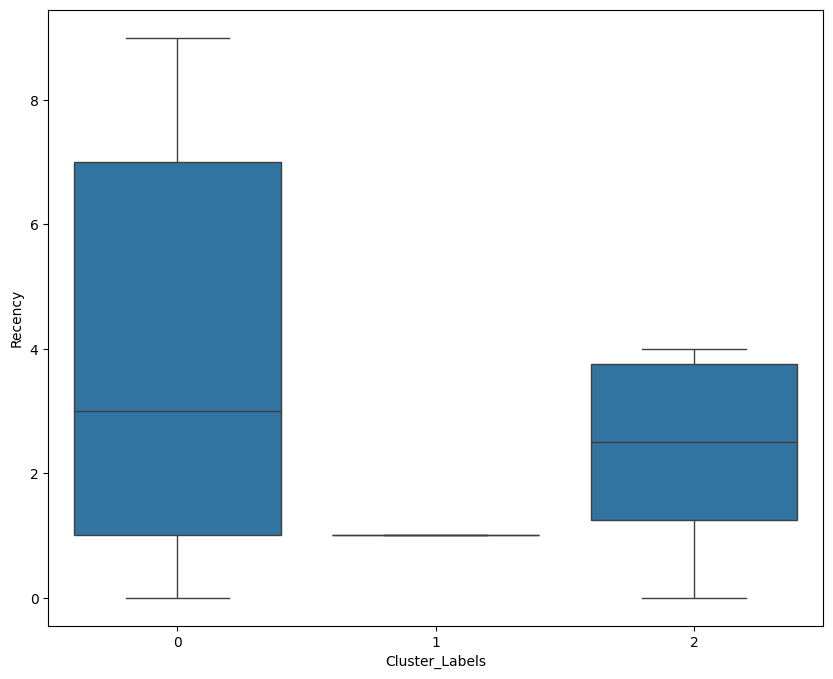

In [42]:
sns.boxplot(x='Cluster_Labels', y='Recency', data=rfm)